# Reverse Time Migration using a vector veflectivity based wave equation

This tutorial will guide the reader through an implementation of a Reverse Time Migration (RTM) algorithm using an acoustic wave equation based on the vector reflectivity.

This tutorial is based on the following paper:

<br>**Seismic modeling with vector reflectivity** (2020)
<br>N. D. Whitmore, J. Ramos-Martinez, Y. Yang, and A. A. Valenciano
<br>SEG Technical Program Expanded Abstracts 2020
<br>https://doi.org/10.1190/segam2020-3424516.1



In [62]:
from examples.seismic.source import RickerSource, TimeAxis, PointSource
from examples.seismic.preset_models import Gardners
from examples.seismic.utils import setup_geometry
from examples.seismic import Model, Receiver
from examples.seismic.vector_reflectivity import VectorReflectivityAcousticWaveSolver

from devito import *

import numpy as np

import matplotlib.pyplot as plt

## Foward modelling

The acoustic wave equation can be rearranged to the following equation:

$$
m \frac{\partial^2 u}{\partial t^2} - \frac{1}{v_p} \nabla \cdot (v_p \nabla u) + 2\nabla \cdot(u\mathbf{R}) - 2u \nabla \cdot \mathbf{R} = S
$$

where $S = S(\mathbf{x}, t)$ is the source term, $v_p$ is the P-wave velocity, $\mathbf{R} = \dfrac{1}{2}\dfrac{\nabla z}{z}$ is the vector reflectivity and $z = v_p\rho$ is the acoustic impedance.

In [63]:
def vector_reflectivity_gardners(vp):
    b = Gardners(vp)
    z = vp/b
    Dzz = np.hstack((np.diff(z, axis=1), np.zeros((1,vp.shape[0])).T))
    Dxz = np.vstack((np.diff(z, axis=0), np.zeros(vp.shape[1])))
    r = [0.5 * Dzz/z, 0.5 * Dxz/z]

    return r

In [64]:
NX = 200
NZ = 120

SHAPE = (NX, NZ)
SPACING = (10., 10.)
ORIGIN = (0., 0.)
NLAYERS = 3
NBL = 50
SPACE_ORDER = 8
DTYPE = np.float32

# Model physical parameters:
vp = np.empty(SHAPE, dtype=DTYPE)

# Define a velocity profile. The velocity is in km/s
vp_top = 1.5
vp_bottom = 3.5
# define a velocity profile in km/s
vp[:] = vp_top  # Top velocity (background)
vp_i = np.linspace(vp_top, vp_bottom, NLAYERS)
for i in range(1, NLAYERS):
    vp[..., i*int(SHAPE[-1] / NLAYERS):] = vp_i[i]  # Bottom velocity

b = Gardners(vp, False)
r = vector_reflectivity_gardners(vp)

In [65]:
# model = Model(vp=vp, r=r, origin=origin, space_order=space_order, shape=shape, dtype=dtype, spacing=spacing, nbl=nbl, bcs='damp')
model = Model(vp=vp, b=b, origin=ORIGIN, space_order=SPACE_ORDER, shape=SHAPE, dtype=DTYPE, spacing=SPACING, nbl=NBL, bcs='damp')

Operator `initdamp` ran in 0.01 s


In [66]:
# function to plot P wave velocit, and the x and z components of R
def img_model(img1, img2, img3, model, title=""):

    plt_options_model = {'cmap': 'jet', 'extent': [model.origin[0],
                         model.origin[0] + model.domain_size[0],
                         model.origin[1] + model.domain_size[1],
                         model.origin[1]]}

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25, 5))

    scale1 = np.max(img1)
    scale2 = np.min(img1)

    imag1 = ax[0].imshow(np.transpose(img1), vmin=scale1, vmax=scale2,
                         **plt_options_model)
    fig.colorbar(imag1, ax=ax[0])
    ax[0].set_title("Vp (km/s)", fontsize=20)
    ax[0].set_xlabel('z (m)', fontsize=20)
    ax[0].set_ylabel('x (m)', fontsize=20)
    ax[0].set_aspect('auto')

    scale3 = np.max(img2)
    scale4 = np.min(img2)

    imag2 = ax[1].imshow(np.transpose(img2), vmin=scale3, vmax=scale4,
                         **plt_options_model)
    fig.colorbar(imag2, ax=ax[1])
    ax[1].set_title("$R_x$ (m$^{-1}$)", fontsize=20)
    ax[1].set_xlabel('z (m)', fontsize=20)
    ax[1].set_ylabel('x (m)', fontsize=20)
    ax[1].set_aspect('auto')

    scale5 = np.max(img3)
    scale6 = np.min(img3)

    imag3 = ax[2].imshow(np.transpose(img3), vmin=scale5, vmax=scale6,
                         **plt_options_model)
    fig.colorbar(imag3, ax=ax[2])
    ax[2].set_title(r"$R_z$ (m$^{-1}$)", fontsize=20)
    ax[2].set_xlabel('z (m)', fontsize=20)
    ax[2].set_ylabel('x (m)', fontsize=20)
    ax[2].set_aspect('auto')

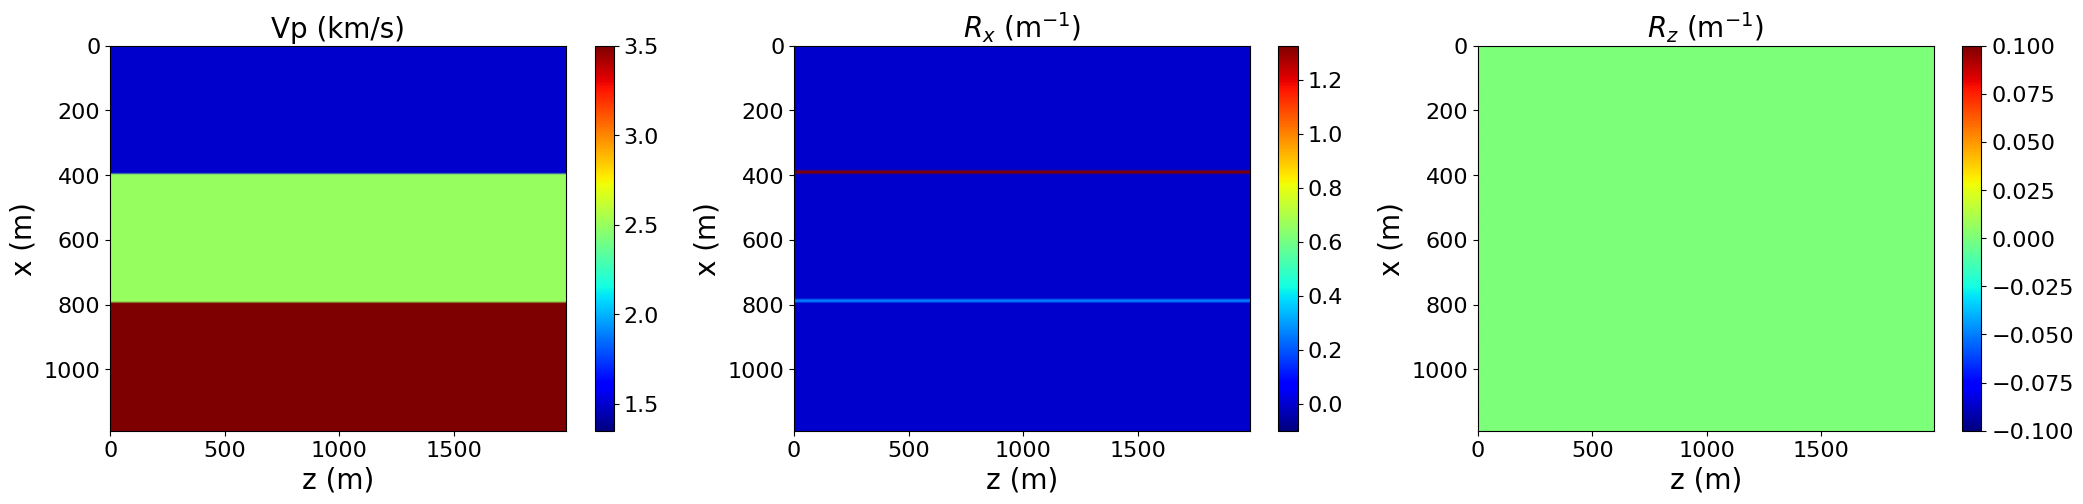

In [67]:
img_model(vp, r[0], r[1], model)

In [68]:
f0 = 0.020  # peak/dominant frequency
# f0 = 0.010  # peak/dominant frequency

s = model.grid.stepping_dim.spacing
damp = model.damp

# Time step in ms and time range:
t0, tn = 0., 1800.
dt = model.critical_dt
time_range = TimeAxis(start=t0, stop=tn, step=dt)

geometry = setup_geometry(model, tn, f0=f0)
geometry = geometry.resample(dt)

In [69]:
# Function that define source and receiver parameters
def source_rec_term(model, u, pos):
    src = RickerSource(name='src', grid=model.grid, f0=f0, time_range=time_range)
    src.coordinates.data[0, :] = pos[0]  # position of source in offset
    src.coordinates.data[0, -1] = pos[1]  # position of source in depth

    # Create symbol for receivers
    rec = Receiver(name='rec', grid=model.grid, npoint=model.shape[0],
                   time_range=time_range)

    rec.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=model.shape[0])
    # postion of receiver at 400 m of depth for pressure field
    rec.coordinates.data[:, 1] = 10.
    
    src_term = src.inject(field=u.forward, expr=src * s**2/model.m)

    rec_term = rec.interpolate(expr=u)

    return rec, rec_term, src_term, src

## The forward operator

In [70]:
def forward(model, pos, geometry):
    u = TimeFunction(name='u', grid=model.grid, save=geometry.nt, time_order=2,
                            space_order=SPACE_ORDER)

    m = model.m
    r = model.r
    vp = model.vp

    pde = m * u.dt2 - 1/vp * div(vp*grad(u, .5), -.5) + 2 * div(u * r,-.5) - 2 * u * div(r, -.5) + model.damp * u.dt
    stencil = Eq(u.forward, solve(pde, u.forward))

    rec, rec_term, src_term, src = source_rec_term(model, u, pos)

    op = Operator([stencil] + src_term + rec_term, subs=model.spacing_map)
    # op(dt=dt, src=src, rec=rec, vp=vp, r_x=r[0], r_y=r[1])
    op(dt=dt)
    
    return u, rec

In [71]:
# generating a shot with the source in the center of the model

pos = np.empty((1, 2), dtype=np.float32)
pos[0, 0] = model.domain_size[0] * .5

u, rec = forward(model, pos[0], geometry)

Operator `Kernel` ran in 0.61 s


In [72]:
u.data.tofile('temp.bin')

In [73]:
u.data.shape

(1215, 300, 220)

In [74]:
# model.r

In [75]:
# solver = VectorReflectivityAcousticWaveSolver(model, geometry, space_order=space_order)
# _, rec, _ = solver.forward()

## Plotting shot data

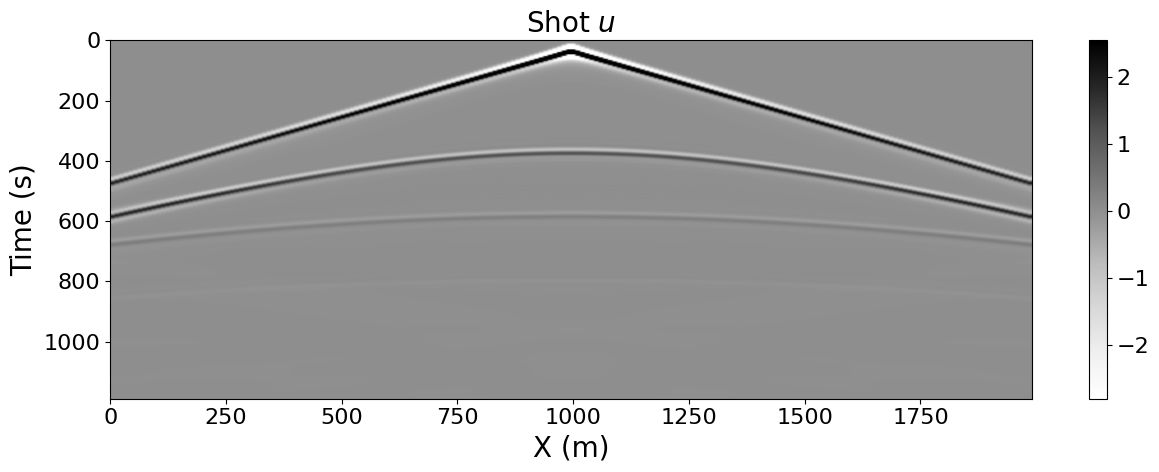

In [76]:
# NBVAL_IGNORE_OUTPUT
slices = [slice(model.nbl, -model.nbl), slice(model.nbl, -model.nbl)]

aspect_ratio = model.shape[0]/model.shape[1]

plt_options_model = {'cmap': 'Greys', 'extent': [model.origin[0], model.origin[0] +
                                                 model.domain_size[0],
                                                 model.origin[1] +
                                                 model.domain_size[1],
                                                 model.origin[1]]}
fig, ax = plt.subplots(figsize=(13, 5))

scale = np.max(rec.data) / 10.

img1 = ax.imshow(rec.data, vmin=scale, vmax=-scale, **plt_options_model)
fig.colorbar(img1, ax=ax)
ax.set_title(r"Shot $u$", fontsize=20)
ax.set_xlabel('X (m)', fontsize=20)
ax.set_ylabel('Time (s)', fontsize=20)
ax.set_aspect('auto')

plt.tight_layout()

## Plotting wavefields snapshots

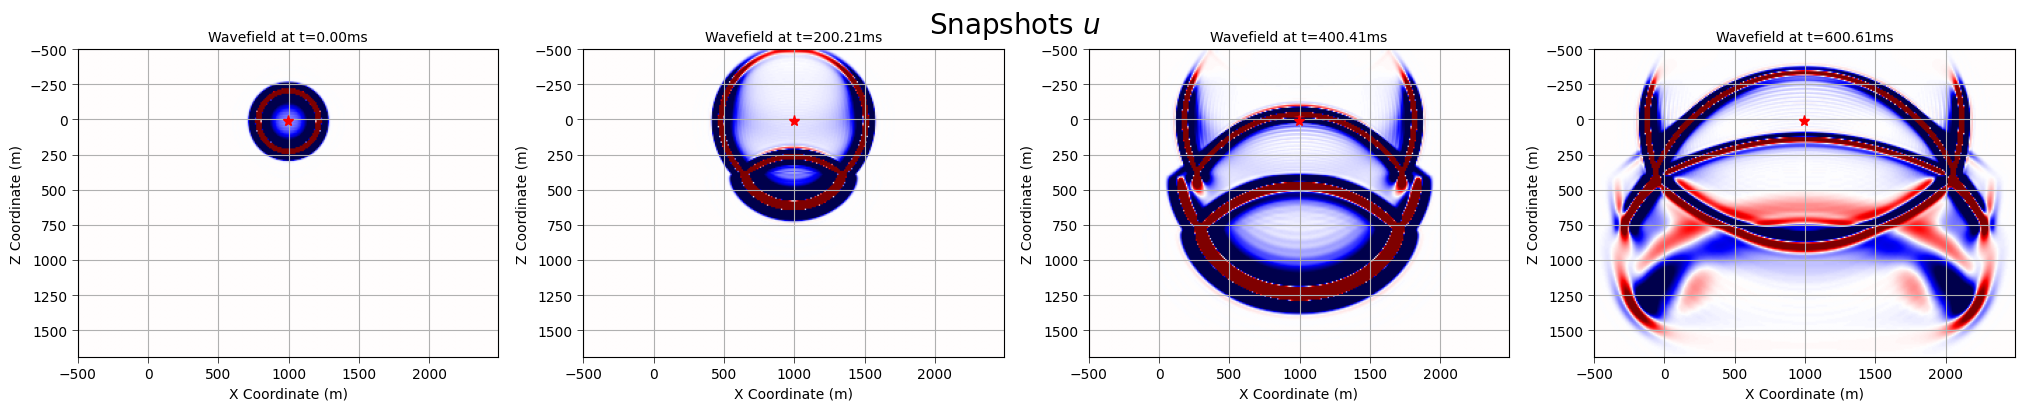

In [77]:
# NBVAL_IGNORE_OUTPUT
# Some useful definitions for plotting if nbl is set to any other value than zero
shape_pad = np.array(shape) + 2 * nbl
origin_pad = tuple([o - s*nbl for o, s in zip(origin, spacing)])
extent_pad = tuple([s*(n-1) for s, n in zip(spacing, shape_pad)])
# Note: flip sense of second dimension to make the plot positive downwards
plt_extent = [origin_pad[0], origin_pad[0] + extent_pad[0],
              origin_pad[1] + extent_pad[1], origin_pad[1]]


def plot(a, title=None):
    # Plot the wavefields, each normalized to scaled maximum of last time step
    kt = (time_range.num - 2) - 1
    amax = 10 * np.max(np.abs(a.data[kt, :, :]))

    nsnaps = 9
    factor = round(time_range.num / nsnaps)

    fig, axes = plt.subplots(1, 4, figsize=(25, 4), sharex=True)
    fig.suptitle(title, size=20)
    for count, ax in enumerate(axes.ravel()):
        snapshot = factor * (count + 1)
        ax.imshow(np.transpose(a.data[snapshot, :, :]), cmap="seismic", vmin=-amax,
                  vmax=+amax, extent=plt_extent)
        ax.plot(model.domain_size[0] * .5, 10, 'red', linestyle='None', marker='*',
                markersize=8, label="Source")
        ax.grid()
        ax.tick_params('both', length=4, width=0.5, which='major', labelsize=10)
        ax.set_title("Wavefield at t=%.2fms" % (factor*count*dt), fontsize=10)
        ax.set_xlabel("X Coordinate (m)", fontsize=10)
        ax.set_ylabel("Z Coordinate (m)", fontsize=10)


plot(u, title="Snapshots $u$")

## The adjoint operator

In [78]:
def adjoint(model, geometry, rec):
    v = TimeFunction(name='v', grid=model.grid, save=geometry.nt, time_order=2,
                    space_order=SPACE_ORDER)
    
    m = model.m
    vp = model.vp
    r = model.r

    pde = m * v.dt2 - div(vp * grad(v/vp, .5), -.5) - 2 * r.T * grad(v, .5) - 2 * v * div(r, -.5) + model.damp * v.dt.T
    stencil = Eq(v.backward, solve(pde, v.backward))

    # rec = PointSource(name='rec', grid=model.grid,
    #                      time_range=geometry.time_axis,
    #                      coordinates=geometry.rec_positions)
    
    rec_term = rec.inject(v.backward, expr = rec * s**2 / m)


    op = Operator([stencil] + rec_term, subs=model.spacing_map)
    op(dt=dt)
    return v

In [ ]:
v = adjoint(model, geometry, rec)

Operator `Kernel` ran in 0.53 s


Data([[[-4.85056735e-05, -1.02665123e-04, -1.56116497e-04, ...,
        -1.18135751e-04, -7.77174209e-05, -3.66717322e-05],
       [-1.02295693e-04, -2.16608329e-04, -3.29683360e-04, ...,
        -2.50371028e-04, -1.64710364e-04, -7.77202658e-05],
       [-1.54215493e-04, -3.26820911e-04, -4.98248090e-04, ...,
        -3.80602141e-04, -2.50383950e-04, -1.18146236e-04],
       ...,
       [-1.54316440e-04, -3.27035086e-04, -4.98573587e-04, ...,
        -3.80616082e-04, -2.50393117e-04, -1.18150529e-04],
       [-1.02361279e-04, -2.16748420e-04, -3.29897535e-04, ...,
        -2.50380079e-04, -1.64716272e-04, -7.77230453e-05],
       [-4.85360179e-05, -1.02730708e-04, -1.56217604e-04, ...,
        -1.18140015e-04, -7.77201858e-05, -3.66730274e-05]],

      [[-4.90842212e-05, -1.03849670e-04, -1.57738032e-04, ...,
        -1.18659795e-04, -7.80615592e-05, -3.68338660e-05],
       [-1.03505110e-04, -2.19060559e-04, -3.32990865e-04, ...,
        -2.51483172e-04, -1.65441306e-04, -7.80648261e

In [ ]:
def ImagingOperator(model, imf, u, v):

    u = VectorTimeFunction(name='u', grid=model.grid, space_order=SPACE_ORDER,
                           time_order=1)
    tau = TensorTimeFunction(name='tau', grid=model.grid, space_order=SPACE_ORDER,
                             time_order=1)
    

    b = model.b
    # Define residual injection at the location of the forward receivers
    rec_vx = PointSource(name='rec_vx', grid=model.grid,
                         time_range=geometry.time_axis,
                         coordinates=geometry.rec_positions)

    rec_vz = PointSource(name='rec_vz', grid=model.grid,
                         time_range=geometry.time_axis,
                         coordinates=geometry.rec_positions)

    H = VectorFunction(name="H", grid=model.grid)

    Hx_sum = [Eq(H[0], H[0] + (v[0]**2))]
    Hz_sum = [Eq(H[-1], H[-1] + (v[-1]**2))]
    H_sum = Hx_sum + Hz_sum

    rec_term_vx = rec_vx.inject(field=u[0].backward, expr=dt*rec_vx*b)
    rec_term_vz = rec_vz.inject(field=u[-1].backward, expr=dt*rec_vz*b)

    rec_expr = rec_term_vx + rec_term_vz

    ixx_update = [Eq(imf[0], imf[0] + (v[0] * u[0])/(H[0] + 10**(-9)))]
    izz_update = [Eq(imf[-1], imf[-1] + (v[-1] * u[-1])/(H[-1] + 10**(-9)))]

    imf_update = ixx_update + izz_update

    return Operator(eqn + rec_expr + H_sum + imf_update, subs=model.spacing_map,
                    name='Imaging')

## `VectorFunction` initialization

In [80]:
# from devito import VectorFunction, Grid, Function, grad

# shape = (5, 5)

# grid = Grid(shape, extent=(1, 1), origin=(0.,0.))

# d1 = np.random.random(shape)
# d2 = np.ones(shape)

# vec_func1 = Function(name='vecfunc1', grid=grid, space_order=2)
# vec_func1.data[:] = d1
# vec_func2 = Function(name='vecfunc2', grid=grid, space_order=2)
# vec_func2.data[:] = d2
# vec_func = VectorFunction(name='vecfunc', grid=grid, space_order=2, components=[vec_func1, vec_func2])
# func = Function(name='func', grid=grid, space_order=2)

In [81]:
# grad(func)
# vec_func